In [794]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o
import scipy as sp

## Result Gathering

In [795]:
main_df = None
directory = "Effort_Estimation_Results_3E_v2/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Beam.csv
Byte-buddy.csv
Camel.csv
Cas.csv
Cassandra.csv
Cxf.csv
Dbeaver.csv
Eclim.csv
Guacamole-client.csv
Hadoop.csv
Hawtio.csv
karaf.csv
Okhttp.csv
Openapi-generator.csv
Orientdb.csv
Redisson.csv
Rest-assured.csv
Spring-framework.csv
Spring-security.csv
Storm.csv
Tika.csv
Traccar.csv


In [796]:
main_df.head()

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,2,NaN,8,1.000000,15.00000,4.13952,2.477916,12.48,42.435515
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,1,NaN,346,0.225434,1.00000,179.03424,107.076009,2229.76,519.589347
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,2,0.707107,35,1.000000,1.00000,18.11040,10.840124,189.60,113.234791
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,13,4.018895,194,0.185567,3.71134,100.38336,60.060503,1232.64,353.641141
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,136,50.585661,1938,0.004128,1.00000,1002.79872,597.273303,12673.28,1634.048307


In [797]:
for column in main_df:
    print(column)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

In [798]:
len(main_df)

775

In [799]:
main_df['refactoring_perc_time_taken'].value_counts()

1.000000     384
2.000000      23
3.000000      11
11.000000      6
5.000000       6
            ... 
19.059569      1
1.123596       1
2.547895       1
41.632653      1
2.103896       1
Name: refactoring_perc_time_taken, Length: 314, dtype: int64

In [800]:
def plotGraph(y_test,y_pred,y_test_str,y_pred_str,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.show()
    return

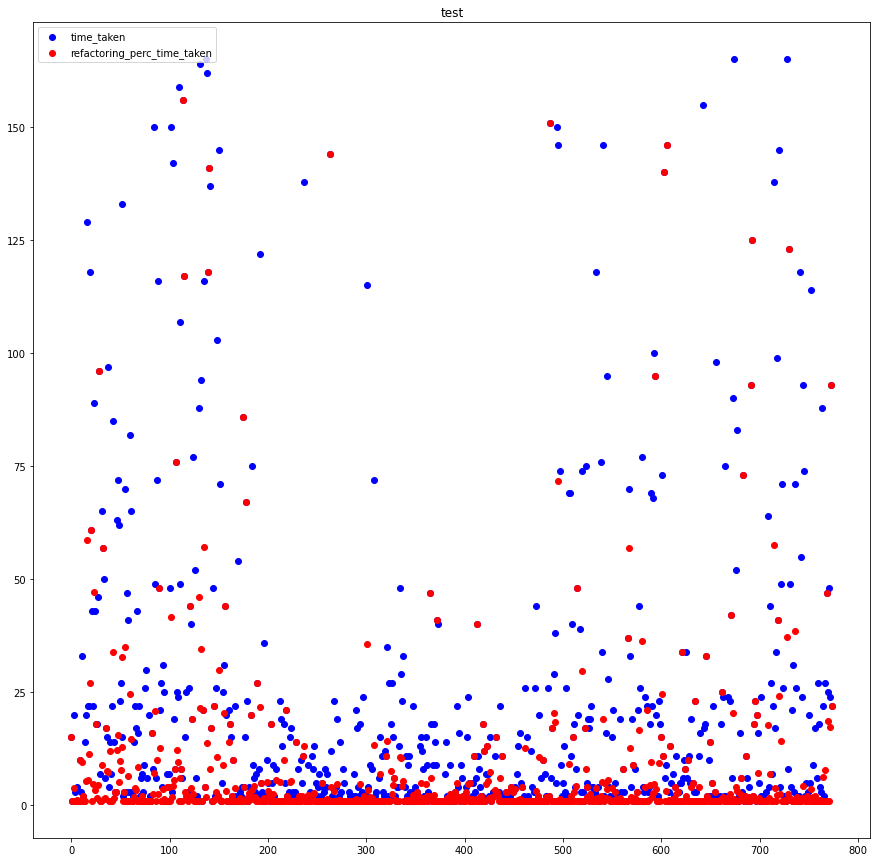

In [801]:
plotGraph(main_df['time_taken'], main_df['refactoring_perc_time_taken'],'time_taken','refactoring_perc_time_taken','test')

In [802]:
def get_final_time_taken(row):
    if row['time_taken'] > row['time_taken_q90']:
        return row['time_taken'] - row['time_taken_q90']
    elif row['time_taken'] > row['time_taken_q80']:
        return row['time_taken'] - row['time_taken_q80']
    elif row['time_taken'] > row['time_taken_q60']:
        return row['time_taken'] - row['time_taken_q60']
    elif row['time_taken'] > row['time_taken_q40']:
        return row['time_taken'] - row['time_taken_q40']
    elif row['time_taken'] > row['time_taken_q20']:
        return row['time_taken'] - row['time_taken_q20']

In [803]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



In [804]:
#plotGraph(main_df['time_taken_final'], main_df['time_taken_mean'],' test')

{'whiskers': [<matplotlib.lines.Line2D at 0x1f7efb3cda0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f7efb374a8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f7efb3cc50>],
 'medians': [<matplotlib.lines.Line2D at 0x1f7efb37ba8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f7efb37f28>],
 'means': []}

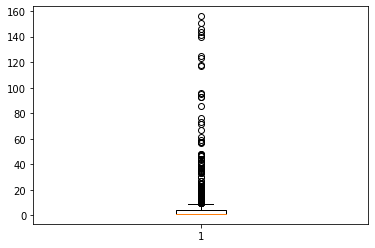

In [805]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [806]:
main_df = main_df[main_df['refactoring_perc_time_taken'] >= 2]
main_df = main_df[main_df['refactoring_perc_time_taken'] <= 40]
#main_df = main_df[main_df['refactoring_perc_time_taken'] <= 20]

#main_df = main_df[main_df['time_taken_final'] <= 60]
#main_df = main_df[main_df['time_taken_final'] > 2]

{'whiskers': [<matplotlib.lines.Line2D at 0x1f7f06466d8>,
 'caps': [<matplotlib.lines.Line2D at 0x1f7f0646da0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f7f0646588>],
 'medians': [<matplotlib.lines.Line2D at 0x1f7f06794e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f7f0679860>],
 'means': []}

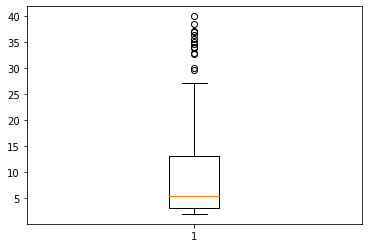

In [807]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [808]:
main_df['time_taken_final'].value_counts()

1.0     43
2.0     26
6.0     17
4.0     17
7.0     15
        ..
50.6     1
21.4     1
43.4     1
8.4      1
19.0     1
Name: time_taken_final, Length: 70, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x1f7efb918d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f7efb91f98>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f7efb91780>],
 'medians': [<matplotlib.lines.Line2D at 0x1f7efb9c6d8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f7efb9ca58>],
 'means': []}

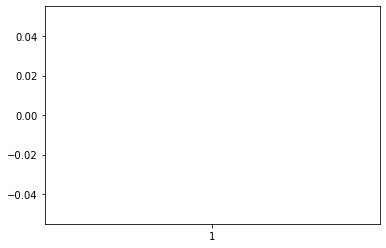

In [809]:
plt.boxplot(main_df['time_taken_final'])

In [810]:
main_df = main_df.fillna(0)

In [811]:
main_df

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken,time_taken_final
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,0.000000,8,1.000000,15.000000,4.13952,2.477916,12.48,42.435515,7.0
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,13,4.018895,194,0.185567,3.711340,100.38336,60.060503,1232.64,353.641141,1.0
9,10,14.676329,1.0,166.0,1.0,2.0,2.0,2.0,4.0,7.0,...,9,0.000000,202,1.000000,10.000000,104.52288,62.535928,1285.12,363.273145,6.0
11,10,14.676329,1.0,166.0,1.0,2.0,2.0,2.0,4.0,7.0,...,6,2.121320,400,0.287500,9.487500,206.97600,123.769958,2584.00,572.195617,12.0
12,10,14.676329,1.0,166.0,1.0,2.0,2.0,2.0,4.0,7.0,...,7,2.160247,14,1.000000,2.000000,7.24416,4.336286,51.84,61.567253,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,17,0.000000,714,0.288515,6.347339,369.45216,220.749445,4643.84,841.170325,1.0
42,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,32,16.743158,635,0.286614,7.738583,328.57440,196.365047,4125.60,778.070877,6.0
1,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,3,0.866025,16,0.750000,18.750000,8.27904,4.955729,64.96,67.284406,5.0
3,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,1,0.000000,535,0.725234,17.405607,276.83040,165.484354,3469.60,694.272395,4.0


(array([137.,  32.,  30.,  18.,  18.,  11.,   3.,   2.,   7.,   5.]),
 array([ 2. ,  5.8,  9.6, 13.4, 17.2, 21. , 24.8, 28.6, 32.4, 36.2, 40. ]),
 <a list of 10 Patch objects>)

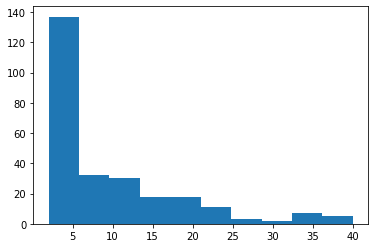

In [812]:
plt.hist(main_df['refactoring_perc_time_taken'])

(array([52., 35., 30., 20.,  7.,  8.,  9.,  8.,  8., 10.,  4.,  8.,  6.,
         5.,  2.,  5.,  7.,  4.,  2.,  5.,  4.,  2.,  2.,  3.,  1.,  0.,
         2.,  0.,  0.,  2.,  0.,  0.,  2.,  2.,  2.,  1.,  2.,  1.,  1.,
         1.]),
 array([ 2.  ,  2.95,  3.9 ,  4.85,  5.8 ,  6.75,  7.7 ,  8.65,  9.6 ,
        10.55, 11.5 , 12.45, 13.4 , 14.35, 15.3 , 16.25, 17.2 , 18.15,
        19.1 , 20.05, 21.  , 21.95, 22.9 , 23.85, 24.8 , 25.75, 26.7 ,
        27.65, 28.6 , 29.55, 30.5 , 31.45, 32.4 , 33.35, 34.3 , 35.25,
        36.2 , 37.15, 38.1 , 39.05, 40.  ]),
 <a list of 40 Patch objects>)

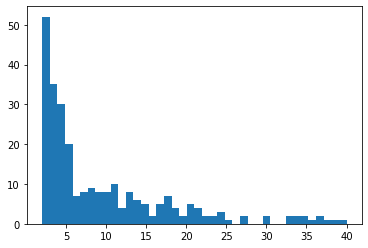

In [813]:
plt.hist(main_df['refactoring_perc_time_taken'],bins=40)

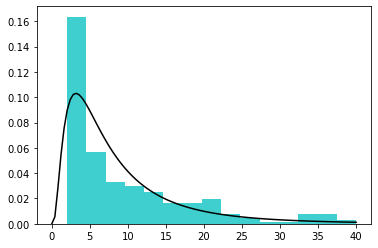

In [814]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=15, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

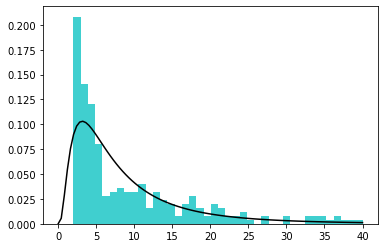

In [815]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=40, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

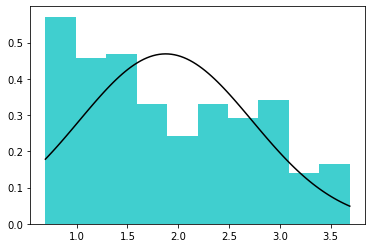

In [816]:
logdata = np.log(main_df['refactoring_perc_time_taken'])
plt.hist(logdata, bins=10, density=True, color='c', alpha=0.75)
xmin = logdata.min()
xmax = logdata.max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
plt.plot(x, pdf, 'k')

In [817]:
len(main_df)

263

In [818]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [819]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

In [820]:
for columns in main_df.columns:
    print(columns)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

### Only taking mean for num_dependency and num_line_affected since there is only one

In [821]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','time_taken_mean',
'time_taken_min',
'time_taken_max',
'time_taken_q10',
'time_taken_q20',
'time_taken_q25',
'time_taken_q30',
'time_taken_q40',
'time_taken_q50',
'time_taken_q60',
'time_taken_q70',
'time_taken_q75',
'time_taken_q80',
'time_taken_q90',
'project_name','commit_compared_with',
'actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
'num_dependency_min',
'num_dependency_max',
'num_dependency_std',
'num_line_affected_min',
'num_line_affected_max',
'num_line_affected_std', 'time_taken_final',
'commit_line_changed',
'refactoring_perc',
 'cocomoII_time_taken',
'geneticP_time_taken',
'softwareMaintenance_time_taken',
'fuzzy_time_taken',
'time_taken_final'
 ]
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [822]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [823]:
X_col = final_col.copy()
X_col.remove('refactoring_perc_time_taken')
Y_col = ['refactoring_perc_time_taken']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [824]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
0,11.000000,11.0,11.0,0.000000,8.000000,8.0,8.0,0.000000,2.000000,2.0,...,58.000000,58.0,58.0,0.000000,17.000000,17.0,17.0,0.00000,85.000000,61.000000
3,23.250000,5.0,63.0,20.780782,20.666667,4.0,64.0,21.993112,2.000000,1.0,...,121.333333,37.0,320.0,98.919006,1.000000,1.0,1.0,0.00000,57.583333,222.666667
9,38.000000,38.0,38.0,0.000000,57.000000,57.0,57.0,0.000000,1.000000,1.0,...,279.000000,279.0,279.0,0.000000,17.000000,17.0,17.0,0.00000,322.000000,764.000000
11,4.000000,4.0,4.0,0.000000,15.000000,15.0,15.0,0.000000,1.000000,1.0,...,108.000000,108.0,108.0,0.000000,1.000000,1.0,1.0,0.00000,371.000000,115.000000
12,15.142857,9.0,23.0,4.740906,9.714286,3.0,41.0,13.960830,1.714286,1.0,...,78.428571,39.0,162.0,51.980308,7.857143,1.0,17.0,8.55236,46.857143,103.000000


In [825]:
y.head()

,refactoring_perc_time_taken
0,15.00000
3,3.71134
9,10.00000
11,9.48750
12,2.00000


## Feature Engineering

In [826]:
from sklearn.preprocessing import MinMaxScaler

def standardize_function(X_train):

    df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X_train), columns = X_train.columns)

    return df_scaled

X = standardize_function(X)

In [827]:
## Normalization
#from sklearn.preprocessing import StandardScaler
#X = StandardScaler().fit_transform(X)
#X =(X - X.mean()) / X.std()

In [828]:
X

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
0,0.082090,0.082090,0.082090,0.000000,0.029412,0.029630,0.029197,0.000000,0.090909,0.090909,...,0.056452,0.066210,0.056387,0.000000,0.016585,0.016585,0.016585,0.000000,0.090381,0.023315
1,0.173507,0.037313,0.470149,0.344912,0.075980,0.014815,0.233577,0.208745,0.090909,0.000000,...,0.129416,0.042237,0.357883,0.453770,0.000976,0.000976,0.000976,0.000000,0.060526,0.091847
2,0.283582,0.283582,0.283582,0.000000,0.209559,0.211111,0.208029,0.000000,0.000000,0.000000,...,0.311060,0.318493,0.310702,0.000000,0.016585,0.016585,0.016585,0.000000,0.348457,0.321323
3,0.029851,0.029851,0.029851,0.000000,0.055147,0.055556,0.054745,0.000000,0.000000,0.000000,...,0.114055,0.123288,0.113924,0.000000,0.000976,0.000976,0.000976,0.000000,0.401815,0.046206
4,0.113006,0.067164,0.171642,0.078688,0.035714,0.011111,0.149635,0.132507,0.064935,0.000000,...,0.079987,0.044521,0.176064,0.238449,0.007666,0.000976,0.016585,0.015248,0.048846,0.041119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,0.082090,0.082090,0.082090,0.000000,0.113971,0.114815,0.113139,0.000000,0.000000,0.000000,...,0.107143,0.116438,0.107020,0.000000,0.000000,0.000000,0.000000,0.000000,0.067514,0.084782
259,0.093284,0.089552,0.097015,0.009583,0.112132,0.081481,0.142336,0.093157,0.045455,0.000000,...,0.221774,0.158676,0.276180,0.209799,0.000488,0.000000,0.000976,0.001029,0.048457,0.123145
260,0.052239,0.014925,0.119403,0.112264,0.041667,0.003704,0.127737,0.147803,0.181818,0.090909,...,0.025986,0.014840,0.070196,0.118808,0.000976,0.000976,0.000976,0.000000,0.138294,0.018511
261,0.029851,0.029851,0.029851,0.000000,0.010110,0.007407,0.010949,0.004746,0.090909,0.090909,...,0.027650,0.037671,0.027618,0.000000,0.000976,0.000976,0.000976,0.000000,0.044646,0.161933


[0.28579269 0.11116752 0.10080521 0.07444072 0.04602827 0.03375043
 0.02853118 0.02553282 0.02313821 0.02137025 0.01749974 0.01523414
 0.0143323  0.01368161 0.01292823 0.01105074 0.01062336 0.00972954
 0.00933592 0.00844205 0.00807734 0.00767533 0.0075259  0.00705297
 0.00667073 0.00628493 0.00584542 0.00570063 0.00526798 0.00503128
 0.0045672  0.00411965 0.00370036 0.00351376 0.00312768 0.002876
 0.0028621  0.002643   0.00252621 0.00234082]


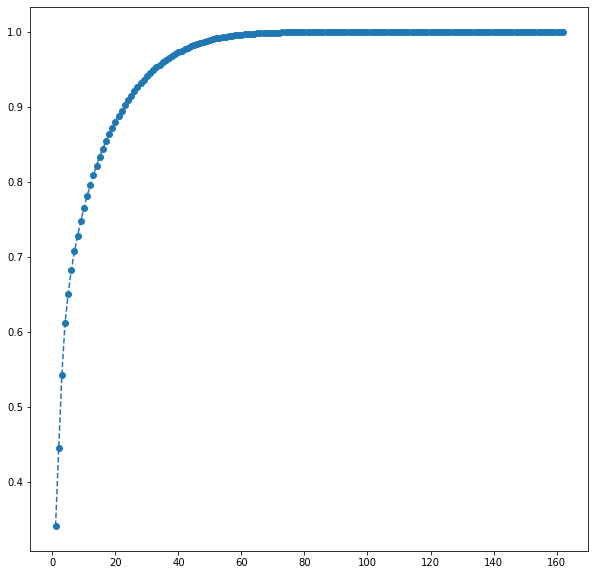

In [829]:
from sklearn.decomposition import PCA
pca2 = PCA()
pca2.fit(X) # fit the dataset into pca model

print(pca.explained_variance_ratio_) # this attribute shows how much variance is explained by each of the seven individual component


plt.figure(figsize= (10, 10)) # size of the chart(size of the vectors)
cumulativeValue = pca2.explained_variance_ratio_.cumsum() # get the cumulative sum

plt.plot(range(1,163), cumulativeValue, marker = 'o', linestyle="--")

In [830]:
from sklearn.decomposition import PCA

pca = PCA(n_components=40)
X = pca.fit_transform(X)


In [831]:
X

array([[-0.36958739, -0.14664479, -0.0590693 , ..., -0.04739205,
         0.02044988, -0.01131443],
       [ 0.64143072,  0.59123897,  1.44472565, ..., -0.02116651,
         0.08641744,  0.00465009],
       [ 1.7830786 , -0.37889614, -0.23713469, ...,  0.01489143,
        -0.11661527,  0.0497018 ],
       ...,
       [-0.29477917,  0.10150106,  0.40967566, ...,  0.08657175,
        -0.03523301, -0.00958971],
       [-0.56356543, -0.21371304, -0.02933622, ..., -0.0099933 ,
        -0.01227204,  0.02034417],
       [-0.12080182, -0.06566057, -0.01801856, ...,  0.19831878,
        -0.32218084,  0.378403  ]])

In [832]:
X = pd.DataFrame(X)

In [833]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.369587,-0.146645,-0.059069,0.142298,-0.186287,-0.016231,0.088987,0.038198,-0.056280,0.003022,...,0.030716,-0.061634,-0.054686,0.023481,0.053790,-0.012902,-0.046284,-0.047392,0.020450,-0.011314
1,0.641431,0.591239,1.444726,-0.063915,0.435441,-0.522784,0.124503,-0.253877,0.200225,0.326805,...,0.370541,0.127187,0.314624,-0.007809,-0.074782,0.212515,-0.180593,-0.021167,0.086417,0.004650
2,1.783079,-0.378896,-0.237135,0.234493,-0.622470,0.562071,-0.395407,-0.461056,1.143412,0.744999,...,-0.146888,-0.151358,-0.095712,0.002315,0.007944,0.210481,-0.023757,0.014891,-0.116615,0.049702
3,-0.305579,-0.112850,-0.038026,0.238846,-0.195626,0.011399,-0.135445,-0.008003,0.069334,-0.028441,...,0.017243,0.179659,-0.050089,-0.089140,-0.063801,0.085239,0.010215,-0.036691,0.025821,-0.038755
4,-0.023681,0.164775,0.574354,-0.013395,0.068631,0.166226,0.075642,-0.143550,0.078045,0.212355,...,-0.092822,0.090775,0.032895,-0.014052,0.009668,0.166266,-0.283725,-0.146590,0.175517,-0.218950


In [834]:
y.head()

,refactoring_perc_time_taken
0,15.00000
3,3.71134
9,10.00000
11,9.48750
12,2.00000


In [835]:
len(y)

263

In [836]:
len(X)

263

In [837]:
len(main_df)

263

In [838]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
final_h20_frame = pd.concat([X,y],axis=1)

In [839]:
final_h20_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,refactoring_perc_time_taken
0,-0.369587,-0.146645,-0.059069,0.142298,-0.186287,-0.016231,0.088987,0.038198,-0.056280,0.003022,...,-0.061634,-0.054686,0.023481,0.053790,-0.012902,-0.046284,-0.047392,0.020450,-0.011314,15.00000
1,0.641431,0.591239,1.444726,-0.063915,0.435441,-0.522784,0.124503,-0.253877,0.200225,0.326805,...,0.127187,0.314624,-0.007809,-0.074782,0.212515,-0.180593,-0.021167,0.086417,0.004650,3.71134
2,1.783079,-0.378896,-0.237135,0.234493,-0.622470,0.562071,-0.395407,-0.461056,1.143412,0.744999,...,-0.151358,-0.095712,0.002315,0.007944,0.210481,-0.023757,0.014891,-0.116615,0.049702,10.00000
3,-0.305579,-0.112850,-0.038026,0.238846,-0.195626,0.011399,-0.135445,-0.008003,0.069334,-0.028441,...,0.179659,-0.050089,-0.089140,-0.063801,0.085239,0.010215,-0.036691,0.025821,-0.038755,9.48750
4,-0.023681,0.164775,0.574354,-0.013395,0.068631,0.166226,0.075642,-0.143550,0.078045,0.212355,...,0.090775,0.032895,-0.014052,0.009668,0.166266,-0.283725,-0.146590,0.175517,-0.218950,2.00000


In [840]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.369587,-0.146645,-0.059069,0.142298,-0.186287,-0.016231,0.088987,0.038198,-0.056280,0.003022,...,0.030716,-0.061634,-0.054686,0.023481,0.053790,-0.012902,-0.046284,-0.047392,0.020450,-0.011314
1,0.641431,0.591239,1.444726,-0.063915,0.435441,-0.522784,0.124503,-0.253877,0.200225,0.326805,...,0.370541,0.127187,0.314624,-0.007809,-0.074782,0.212515,-0.180593,-0.021167,0.086417,0.004650
2,1.783079,-0.378896,-0.237135,0.234493,-0.622470,0.562071,-0.395407,-0.461056,1.143412,0.744999,...,-0.146888,-0.151358,-0.095712,0.002315,0.007944,0.210481,-0.023757,0.014891,-0.116615,0.049702
3,-0.305579,-0.112850,-0.038026,0.238846,-0.195626,0.011399,-0.135445,-0.008003,0.069334,-0.028441,...,0.017243,0.179659,-0.050089,-0.089140,-0.063801,0.085239,0.010215,-0.036691,0.025821,-0.038755
4,-0.023681,0.164775,0.574354,-0.013395,0.068631,0.166226,0.075642,-0.143550,0.078045,0.212355,...,-0.092822,0.090775,0.032895,-0.014052,0.009668,0.166266,-0.283725,-0.146590,0.175517,-0.218950


In [841]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=16)

In [694]:
h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 40 mins
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,5 months and 4 days !!!
H2O_cluster_name:,H2O_from_python_tanji_tndn4a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.906 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [842]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_h20_frame)
train,test = full.split_frame(ratios=[.7])


x = train.columns
y = "refactoring_perc_time_taken"
x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [843]:
train[x].types

{'0': 'real',
 '1': 'real',
 '2': 'real',
 '3': 'real',
 '4': 'real',
 '5': 'real',
 '6': 'real',
 '7': 'real',
 '8': 'real',
 '9': 'real',
 '10': 'real',
 '11': 'real',
 '12': 'real',
 '13': 'real',
 '14': 'real',
 '15': 'real',
 '16': 'real',
 '17': 'real',
 '18': 'real',
 '19': 'real',
 '20': 'real',
 '21': 'real',
 '22': 'real',
 '23': 'real',
 '24': 'real',
 '25': 'real',
 '26': 'real',
 '27': 'real',
 '28': 'real',
 '29': 'real',
 '30': 'real',
 '31': 'real',
 '32': 'real',
 '33': 'real',
 '34': 'real',
 '35': 'real',
 '36': 'real',
 '37': 'real',
 '38': 'real',
 '39': 'real'}

In [844]:
train[y].types

{'refactoring_perc_time_taken': 'real'}

In [845]:
aml = H2OAutoML(max_models=16, seed=16, exclude_algos=['XGBoost'], exploitation_ratio=0.1)
#aml = H2OAutoML(max_models=10, seed=1, include_algos=['GLM'])
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |███████
20:27:28.29: Skipping training of model GBM_5_AutoML_20220206_202721 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_5_AutoML_20220206_202721.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 177.0.


█████████████████████████████████████████████████| 100%


In [846]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GLM_1_AutoML_20220206_202721,72.5155,8.5156,72.5155,6.6325,0.786103
GBM_lr_annealing_selection__AutoML_20220206_202721_select_model,76.3971,8.74054,76.3971,6.66085,0.793593
StackedEnsemble_AllModels_AutoML_20220206_202721,77.3685,8.79593,77.3685,6.82188,0.800755
StackedEnsemble_BestOfFamily_AutoML_20220206_202721,77.7764,8.81909,77.7764,6.83361,0.803761
GBM_4_AutoML_20220206_202721,79.9043,8.93892,79.9043,6.77755,0.806918
GBM_grid__1_AutoML_20220206_202721_model_2,81.2092,9.01161,81.2092,6.99954,0.814822
GBM_grid__1_AutoML_20220206_202721_model_3,81.5284,9.02931,81.5284,7.07391,0.822167
GBM_3_AutoML_20220206_202721,81.9541,9.05285,81.9541,6.87165,0.814913
GBM_2_AutoML_20220206_202721,83.2539,9.12436,83.2539,7.03583,0.825404
DeepLearning_grid__3_AutoML_20220206_202721_model_1,83.6629,9.14675,83.6629,6.84289,nan


In [873]:
model = h2o.get_model(lb[1,'model_id'])

In [874]:
model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_lr_annealing_selection__AutoML_20220206_202721_select_model


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,33.0,33.0,3936.0,2.0,5.0,3.39394,4.0,6.0,4.878788




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 39.82801886395658
RMSE: 6.310944371800197
MAE: 4.768075757780991
RMSLE: 0.5943132172992295
Mean Residual Deviance: 39.82801886395658

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 76.39705984969578
RMSE: 8.740541164578758
MAE: 6.660850379287007
RMSLE: 0.7935929097041727
Mean Residual Deviance: 76.39705984969578

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,6.664957,0.61611253,6.0415416,6.5614715,6.136715,7.454223,7.130834
1,mean_residual_deviance,76.534355,17.236164,54.175873,74.59107,83.41383,100.827034,69.66398
2,mse,76.534355,17.236164,54.175873,74.59107,83.41383,100.827034,69.66398
3,r2,-0.037364833,0.07562299,-0.08251117,-0.043537874,-0.03714624,-0.1105397,0.08691082
4,residual_deviance,76.534355,17.236164,54.175873,74.59107,83.41383,100.827034,69.66398
5,rmse,8.703584,0.98868144,7.360426,8.636612,9.133118,10.041266,8.346496
6,rmsle,0.7919831,0.065468974,0.78951794,0.6948742,0.7723,0.8413658,0.8618577



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-02-06 20:32:04,0.140 sec,0.0,8.634822,6.734870,74.560151
1,,2022-02-06 20:32:04,0.146 sec,5.0,8.039725,6.237046,64.637174
2,,2022-02-06 20:32:04,0.152 sec,10.0,7.604226,5.912142,57.824260
3,,2022-02-06 20:32:04,0.157 sec,15.0,7.214464,5.572975,52.048488
4,,2022-02-06 20:32:04,0.163 sec,20.0,6.948750,5.338612,48.285123
5,,2022-02-06 20:32:04,0.169 sec,25.0,6.653867,5.052228,44.273945
6,,2022-02-06 20:32:04,0.175 sec,30.0,6.477671,4.856627,41.960218
7,,2022-02-06 20:32:04,0.178 sec,33.0,6.310944,4.768076,39.828019



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,38,2465.568115,1.000000,0.062881
1,4,2461.700928,0.998432,0.062782
2,16,2368.463379,0.960616,0.060404
3,13,2319.977051,0.940950,0.059168
4,3,2128.514893,0.863296,0.054285
5,20,1994.307373,0.808863,0.050862
6,19,1952.325806,0.791836,0.049791
7,22,1893.519043,0.767985,0.048292
8,35,1748.438110,0.709142,0.044591
9,5,1596.273926,0.647426,0.040711



See the whole table with table.as_data_frame()


In [875]:
preds = model.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [876]:
preds

predict
9.60507
17.2769
9.63858
10.3956
9.20024
11.103
10.2865
11.6719
11.3391
9.79068


In [877]:
pd_preds = preds.as_data_frame()
pd_preds['predict'].value_counts()

8.043489     1
11.195037    1
11.783174    1
13.374498    1
9.035132     1
            ..
7.493006     1
8.609497     1
13.986437    1
9.183696     1
7.831347     1
Name: predict, Length: 86, dtype: int64

In [878]:
train

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,refactoring_perc_time_taken
-0.369587,-0.146645,-0.0590693,0.142298,-0.186287,-0.0162308,0.0889868,0.0381976,-0.0562805,0.00302174,0.00313469,-0.0534581,-0.265786,-0.0460633,-0.0551663,-0.0424004,-0.0142035,0.0128443,0.0675391,-0.245914,-0.104736,-0.0766595,-0.0771164,0.0840306,-0.0433431,0.108764,0.0368969,0.0348922,0.0270392,0.0117261,0.030716,-0.0616339,-0.0546858,0.0234812,0.0537903,-0.0129024,-0.0462837,-0.0473921,0.0204499,-0.0113144,15
1.78308,-0.378896,-0.237135,0.234493,-0.62247,0.562071,-0.395407,-0.461056,1.14341,0.744999,-0.0228709,-0.28982,0.995764,-0.612009,-0.191317,0.462518,0.527036,-0.484139,0.104786,-0.332816,-0.226806,-0.104539,0.149674,-0.0246158,-0.103018,0.159453,-0.373078,0.478431,-0.128314,0.535944,-0.146888,-0.151358,-0.0957121,0.00231474,0.00794356,0.210481,-0.0237567,0.0148914,-0.116615,0.0497018,10
-0.0236812,0.164775,0.574354,-0.0133949,0.0686307,0.166226,0.0756424,-0.14355,0.0780455,0.212355,-0.122596,0.0482638,-0.11259,-0.156994,0.113399,0.133932,-0.120376,-0.0722656,0.656033,0.596587,-0.368171,0.172911,-0.0478551,0.120974,0.526029,0.107397,-0.0318123,0.0364958,0.0244741,0.145897,-0.0928216,0.0907749,0.0328951,-0.0140523,0.0096683,0.166266,-0.283725,-0.14659,0.175517,-0.21895,2
-0.468981,-0.146387,-0.0327336,0.154991,0.0926157,0.0025226,-0.117763,-0.112408,0.0530316,0.0339402,-0.0304056,-0.0128136,0.0744735,-0.0162867,-0.00323674,0.00956647,-0.0815945,0.0421991,0.0196373,0.0517846,0.0765656,-0.0106101,-0.0262338,-0.033026,-0.0623843,-0.0223339,-0.00388837,0.0510841,0.0311135,-0.0630426,0.0465132,-0.028193,0.0254306,-0.00556856,0.0141126,0.04099,0.00212882,0.00428838,-0.0323242,0.0182683,5.34091
-0.423652,-0.160857,-0.0314702,0.114277,-0.202046,0.0490404,-0.10539,-0.00153383,0.0172216,-0.117564,0.014681,-0.0377562,-0.0860738,0.0229729,-0.0382422,0.00243979,-0.0221183,-0.0250018,0.0316441,-0.0227116,-0.0288912,-0.0149839,-0.00573898,-0.034791,-0.0144664,0.0327515,-0.010935,0.0196837,0.0427093,-0.0666997,0.0240308,-0.0819973,-0.0261984,-0.00708185,-0.017237,0.0537276,-0.0402233,-0.0393762,-0.0625368,-0.0220545,5.47893
0.510559,-0.145329,0.422547,-0.422917,-0.351168,0.148344,-0.130063,0.166139,0.0246007,0.235991,0.327504,0.487188,0.00337429,0.265129,-0.0885501,0.0654889,0.00119322,0.0850801,-0.114308,0.32658,0.486603,-0.155562,-0.0280675,0.0213453,-0.00843436,0.341137,0.0466464,-0.351685,0.356972,0.222457,-0.206273,-0.182543,-0.430988,-0.0872218,0.153403,-0.162127,-0.363679,0.0841633,-0.100327,0.104595,11.2734
0.0490666,-0.185778,0.267436,-0.363537,-0.12216,0.0463008,0.00476987,0.270706,-0.0450941,0.20892,0.129568,0.0999162,-0.00812381,0.171213,-0.0739855,-0.0273892,-0.0738144,-0.0418051,-0.0834457,0.187359,-0.00312967,0.0523201,-0.0511368,-0.0308061,-0.128919,0.139385,-0.139267,0.104198,0.00997128,0.0315881,0.0135577,0.0100412,-0.0374345,0.0721505,-0.0984987,0.0922491,0.00702483,-0.0085245,0.0331088,0.0305066,27.154
-0.404102,-0.275177,-0.0569207,-0.0946206,-0.0903089,0.067429,-0.0496402,-0.117525,-0.0643227,-0.105709,-0.00287532,0.0798787,0.0423494,0.0472533,-0.0488442,-0.0771119,-0.0349925,0.0241455,-0.00675931,-0.00885211,0.00127104,0.0806825,-0.0873874,-0.0125663,0.0263898,-0.0428022,0.0476422,-0.0554054,-0.072327,-0.0457592,-0.0216848,-0.00624665,0.0948699,0.0398912,0.0186146,-0.0785374,0.00126022,0.025106,0.0112103,0.0398039,4.78661
-0.603714,-0.188802,-0.0487808,0.0360018,0.009927,0.0734103,0.0100286,0.237342,-0.0884904,0.091248,-0.075112,0.0416007,0.0583225,-0.0220884,0.0225005,0.025209,-0.0648981,0.0381028,-0.0961831,-0.0157283,0.00352062,-0.0422187,-0.0258034,0.0171434,0.0675659,-0.00751249,-0.0175758,0.0276188,0.0414816,0.072575,-0.00486863,0.0349864,0.0131688,0.0201669,0.0433685,-0.00210328,0.0163676,-0.0184166,0.0435271,0.0262536,3.39474
-0.593585,1.0992,-0.906541,-0.486836,-0.0784226,-0.151048,-0.326643,-0.046294,0.00128499,0.101337,-0.0958143,0.143956,-0.0439604,-0.0898125,0.0

{'whiskers': [<matplotlib.lines.Line2D at 0x1f7f2343048>,
 'caps': [<matplotlib.lines.Line2D at 0x1f7f2343748>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f7f2336eb8>],
 'medians': [<matplotlib.lines.Line2D at 0x1f7f2343e48>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f7f234b208>],
 'means': []}

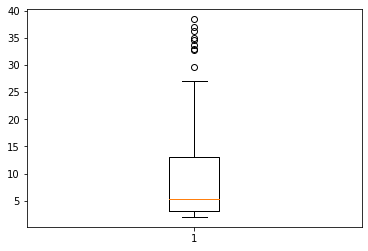

In [879]:
pd_train = train.as_data_frame()
plt.boxplot(pd_train['refactoring_perc_time_taken'])

In [880]:
main_df['actual_num_of_classes_touched_max'].mean()

10.083650190114069

In [881]:
len(main_df['actual_num_of_classes_touched_max'])

263

In [882]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 1000])

263

In [883]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 100])

261

In [884]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 50])

254

In [885]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 20])

226

In [886]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 10])

184

{'whiskers': [<matplotlib.lines.Line2D at 0x1f7f23760f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f7f2376fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f7f23768d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f7f268c710>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f7f268ca90>],
 'means': []}

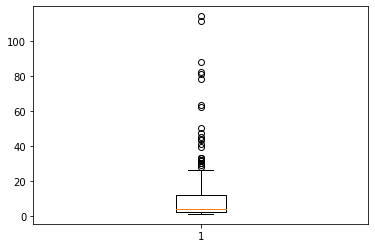

In [887]:
plt.boxplot(main_df['actual_num_of_classes_touched_max'])

In [888]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 1000]

{'whiskers': [<matplotlib.lines.Line2D at 0x1f7f26e2048>,
 'caps': [<matplotlib.lines.Line2D at 0x1f7f26e2710>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f7f26d5eb8>],
 'medians': [<matplotlib.lines.Line2D at 0x1f7f26e2e10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f7f26ed1d0>],
 'means': []}

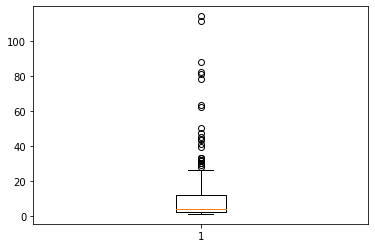

In [889]:
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1f7f273f940>,
 'caps': [<matplotlib.lines.Line2D at 0x1f7f274b080>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f7f273f7f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f7f274b780>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f7f274bb00>],
 'means': []}

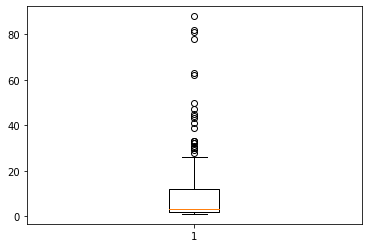

In [890]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 100]
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

In [891]:
pd_test = test.as_data_frame()
pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken']

In [892]:
pd_preds

,predict,actual_time_taken
0,9.605070,3.711340
1,17.276934,9.487500
2,9.638578,18.000000
3,10.395561,8.813559
4,9.200240,17.000000
...,...,...
81,8.435012,2.579845
82,15.239013,4.263158
83,10.629422,6.347339
84,7.917166,18.750000


{'whiskers': [<matplotlib.lines.Line2D at 0x1f7f279a908>,
 'caps': [<matplotlib.lines.Line2D at 0x1f7f27a9048>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f7f279a7b8>],
 'medians': [<matplotlib.lines.Line2D at 0x1f7f27a9748>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f7f27a9ac8>],
 'means': []}

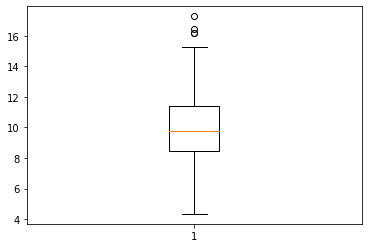

In [893]:
plt.boxplot(pd_preds['predict'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1f7f2806588>,
 'caps': [<matplotlib.lines.Line2D at 0x1f7f2806c88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f7f2806438>],
 'medians': [<matplotlib.lines.Line2D at 0x1f7f28103c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f7f2810748>],
 'means': []}

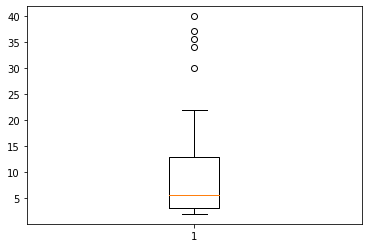

In [894]:
plt.boxplot(pd_preds['actual_time_taken'])

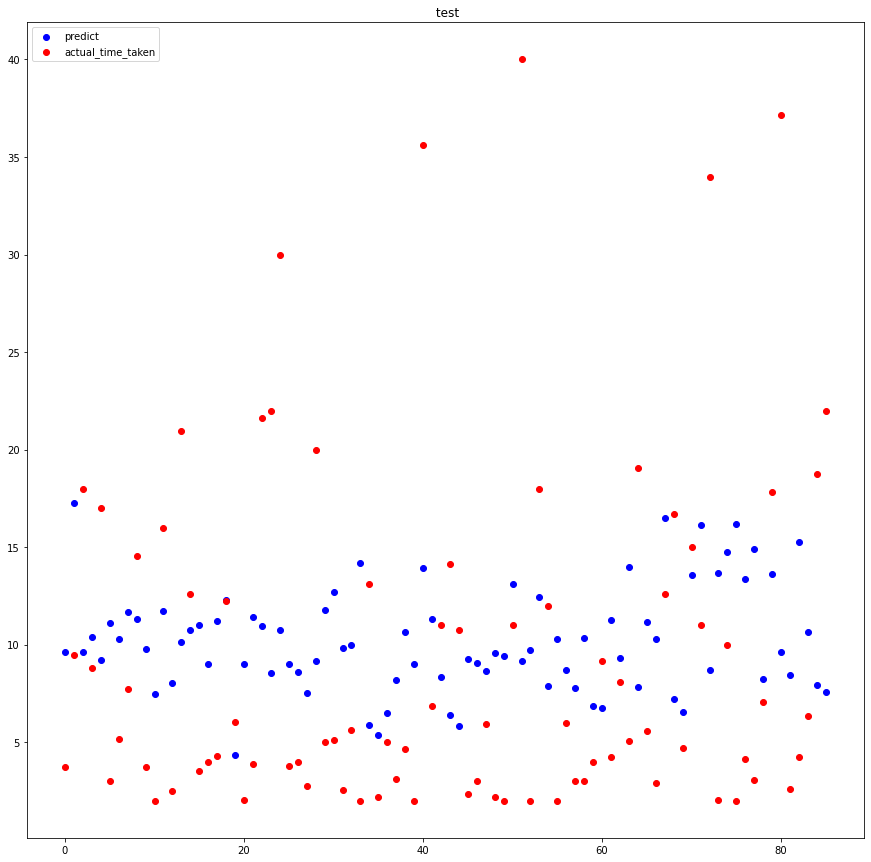

In [895]:
plotGraph(pd_preds['predict'], pd_preds['actual_time_taken'],'predict','actual_time_taken',' test')

In [896]:
visualization = pd_preds[pd_preds['predict'] <= 20]
visualization = pd_preds[pd_preds['actual_time_taken'] <= 20]


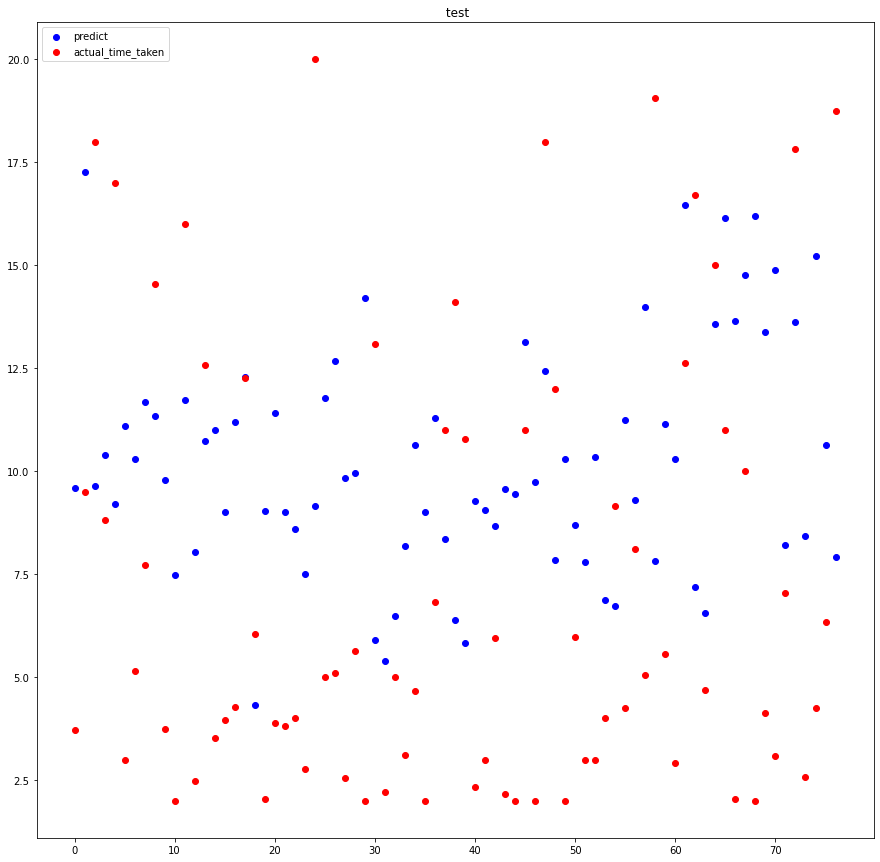

In [897]:
plotGraph(visualization['predict'], visualization['actual_time_taken'],'predict','actual_time_taken',' test')

In [898]:
# save the model
model_path = h2o.save_model(model=model, path="models/EffortEstimationModelv2", force=True)

Documentation at the following

https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/explanation/_explain.html

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

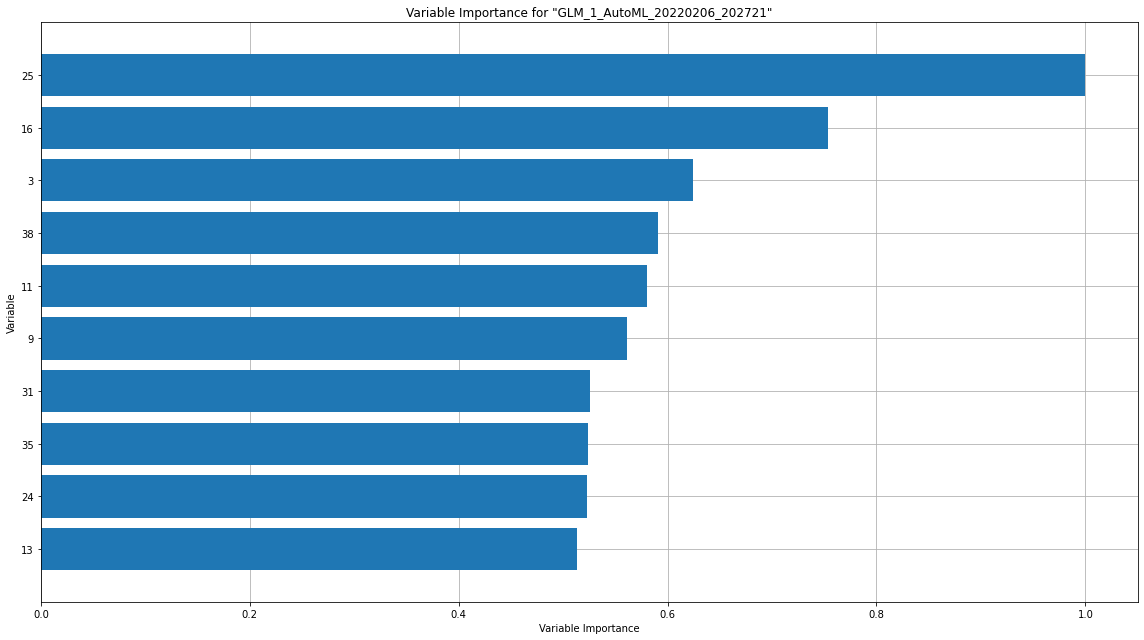

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

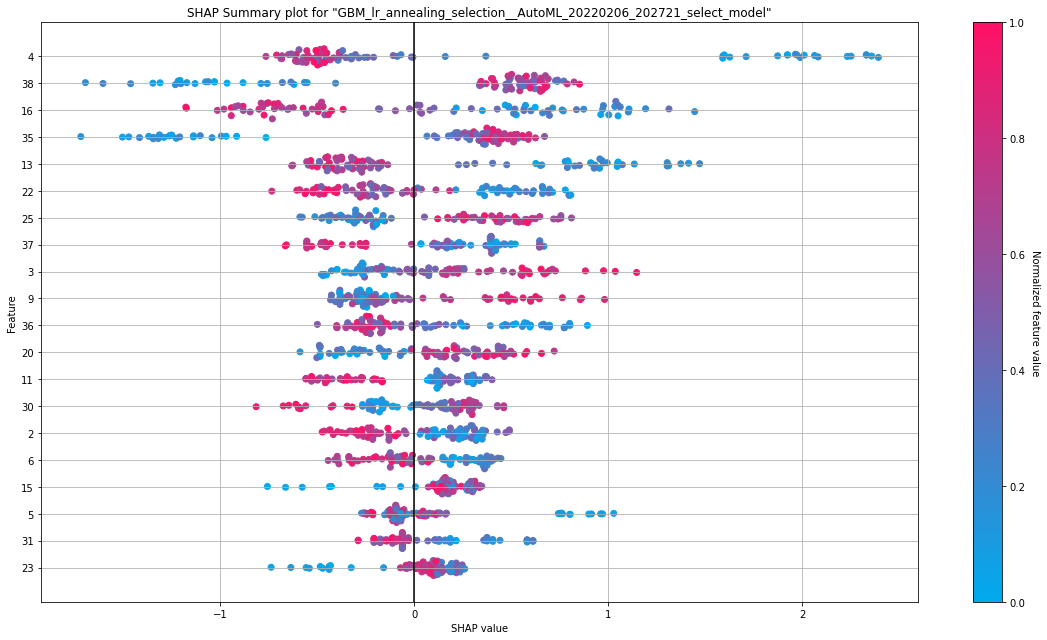

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

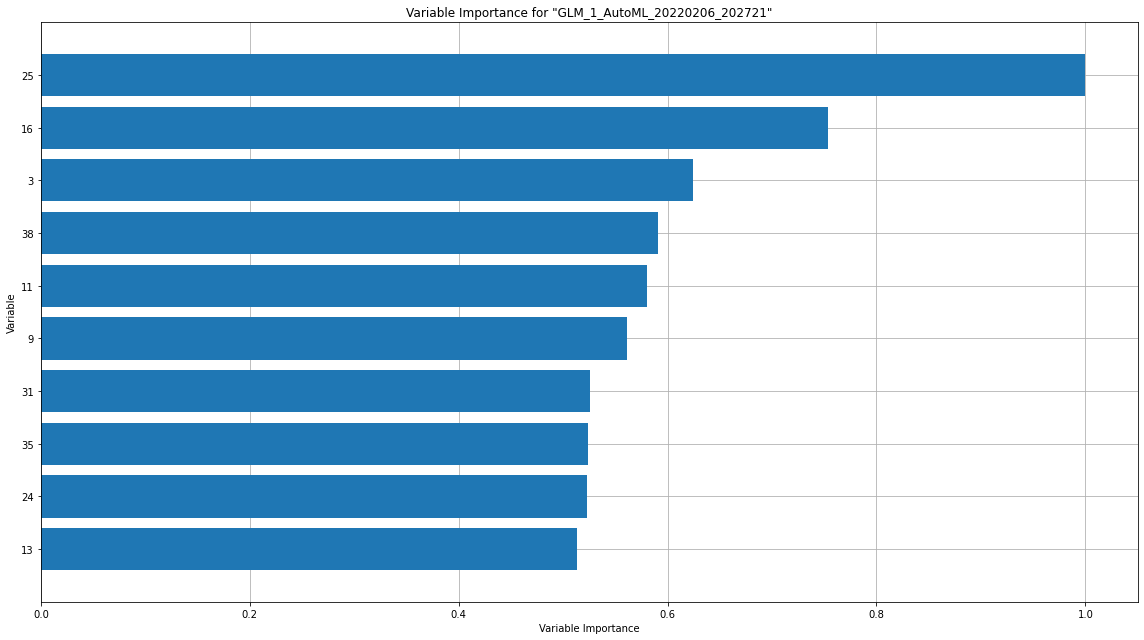

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

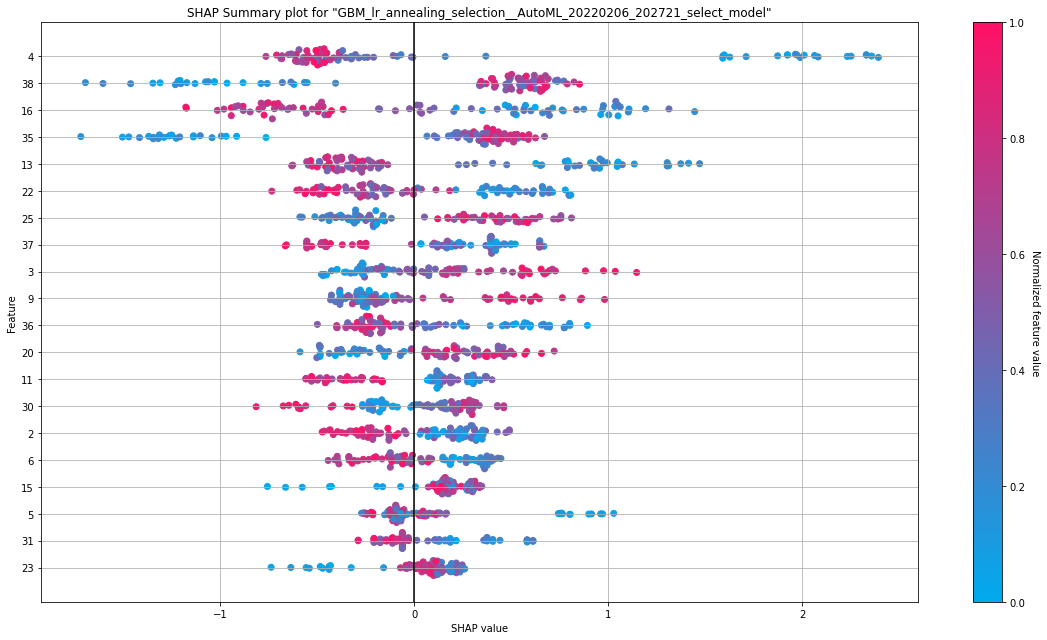

In [899]:
aml.explain(test, include_explanations=["varimp",'shap_summary'])

In [900]:
## Test calling of model

model_path = "models/EffortEstimationModelv2/GBM_lr_annealing_selection__AutoML_20220206_202721_select_model"
saved_model = h2o.load_model(model_path)

In [902]:
preds_read_model = model.predict(test)
pd_preds_read_model = preds_read_model.as_data_frame()
pd_preds_read_model['actual_time_taken'] = pd_test['refactoring_perc_time_taken']

gbm prediction progress: |████████████████████████████████████████████████| 100%


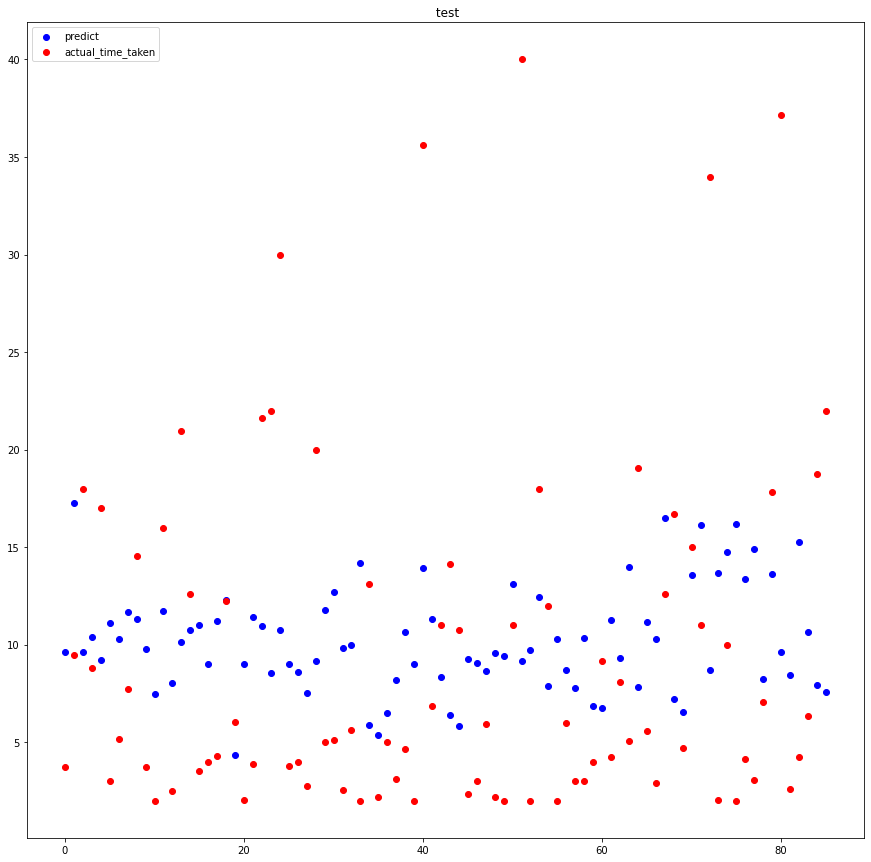

In [903]:
plotGraph(pd_preds_read_model['predict'], pd_preds_read_model['actual_time_taken'],'predict','actual_time_taken',' test')

In [ ]:
#aml.explain_row(test, row_index=0)

In [ ]:
#h2o.shutdown()